<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

# 파이토치로 구현한 3DGS 렌더러

훈련이 끝난 3DGS 데이터가 담겨있는 '.PLY' 파일을 읽어들여서 3차원 렌더링을 합니다.

## 1. Import Libraries

Libraries: `plyfile` (PLY parsing), `torch` (GPU tensors), `numpy`, `PIL` (images), `matplotlib` (visualization), `tqdm` (progress bars).

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from plyfile import PlyData  # For loading .ply files

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090 Laptop GPU


## 2. Spherical Harmonics Constants

Normalization constants for SH basis functions (degrees 0-3, total 16 coefficients).

**CUDA Reference**: `forward.cu` lines 19-68

In [2]:
# Spherical Harmonics coefficients (up to degree 3)
SH_C0 = 0.28209479177387814
SH_C1_x = 0.4886025119029199
SH_C1_y = 0.4886025119029199
SH_C1_z = 0.4886025119029199
SH_C2_xy = 1.0925484305920792
SH_C2_xz = 1.0925484305920792
SH_C2_yz = 1.0925484305920792
SH_C2_zz = 0.31539156525252005
SH_C2_xx_yy = 0.5462742152960396
SH_C3_yxx_yyy = 0.5900435899266435
SH_C3_xyz = 2.890611442640554
SH_C3_yzz_yxx_yyy = 0.4570457994644658
SH_C3_zzz_zxx_zyy = 0.3731763325901154
SH_C3_xzz_xxx_xyy = 0.4570457994644658
SH_C3_zxx_zyy = 1.445305721320277
SH_C3_xxx_xyy = 0.5900435899266435

print("Spherical Harmonics constants loaded.")

Spherical Harmonics constants loaded.


## 3. Core Functions

### 3.1 Spherical Harmonics Evaluation

Computes view-dependent RGB colors from SH coefficients.

**CUDA Reference**: `forward.cu` lines 19-68 (computeColorFromSH)

In [ ]:
def evaluate_sh(f_dc, f_rest, points, c2w):
    """
    Evaluate spherical harmonics to get view-dependent colors.
    
    CUDA Reference: forward.cu lines 19-68 (computeColorFromSH)
    
    Args:
        f_dc: [N, 3, 1] DC coefficients (base color)
        f_rest: [N, 3, 15] Higher-degree SH coefficients
        points: [N, 3] 3D Gaussian centers
        c2w: [4, 4] Camera-to-world matrix
    
    Returns:
        colors: [N, 3] RGB in [0, 1]. Uses clamp_min(sh2rgb + 0.5, 0.0) NOT sigmoid.
    """
    # Combine DC and rest into single tensor [N, 3, 16]
    sh = torch.cat([f_dc, f_rest], dim=2)  # [N, 3, 16]

    view_dir = points - c2w[:3, 3].unsqueeze(0)  # [N, 3]
    view_dir = view_dir / (view_dir.norm(dim=-1, keepdim=True) + 1e-8)
    x, y, z = view_dir[:, 0], view_dir[:, 1], view_dir[:, 2]

    xx, yy, zz = x * x, y * y, z * z
    xy, xz, yz = x * y, x * z, y * z

    Y0 = torch.full_like(x, SH_C0)  # [N]
    Y1 = - SH_C1_y * y
    Y2 = SH_C1_z * z
    Y3 = - SH_C1_x * x
    Y4 = SH_C2_xy * xy
    Y5 = SH_C2_yz * yz
    Y6 = SH_C2_zz * (3 * zz - 1)
    Y7 = SH_C2_xz * xz
    Y8 = SH_C2_xx_yy * (xx - yy)
    Y9 = SH_C3_yxx_yyy * y * (3 * xx - yy)
    Y10 = SH_C3_xyz * x * y * z
    Y11 = SH_C3_yzz_yxx_yyy * y * (4 * zz - xx - yy)
    Y12 = SH_C3_zzz_zxx_zyy * z * (2 * zz - 3 * xx - 3 * yy)
    Y13 = SH_C3_xzz_xxx_xyy * x * (4 * zz - xx - yy)
    Y14 = TODO
    Y15 = TODO
    Y = torch.stack([Y0, Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11, Y12, Y13, Y14, Y15],
                    dim=1)  # [N, 16]
    
    # Official gaussian-splatting uses: clamp_min(sh2rgb + 0.5, 0.0)
    # NOT sigmoid! This is critical for color accuracy and clarity
    # sh is [N, 3, 16], Y is [N, 16] -> unsqueeze Y to [N, 1, 16] for broadcasting
    sh2rgb = (sh * Y.unsqueeze(1)).sum(dim=2)  # [N, 3]
    colors = torch.clamp_min(sh2rgb + 0.5, 0.0)
    return colors

print("evaluate_sh() defined")

evaluate_sh() defined


### 3.2 Projection and Coordinate Transformations

Transforms 3D world positions to 2D screen coordinates and camera-space depth for sorting.

**CUDA Reference**: `forward.cu` lines 196-199

In [4]:
def project_points(pc, c2w, fx, fy, cx, cy):
    """
    Project 3D points to 2D screen coordinates.
    
    Args:
        pc: [N, 3] World space positions
        c2w: [4, 4] Camera-to-world matrix
        fx, fy: Focal lengths in pixels
        cx, cy: Principal point in pixels
    
    Returns:
        uv: [N, 2] Pixel coordinates (u, v)
        x, y, z: [N] Camera space coordinates
    """
    w2c = torch.eye(4, device=pc.device)
    R = c2w[:3, :3]
    t = c2w[:3, 3]
    w2c[:3, :3] = R.t()
    w2c[:3, 3] = -R.t() @ t

    PC = ((w2c @ torch.concatenate(
        [pc, torch.ones_like(pc[:, :1])], dim=1).t()).t())[:, :3]
    x, y, z = PC[:, 0], PC[:, 1], PC[:, 2]  # Camera space

    uv = torch.stack([fx * x / z + cx, fy * y / z + cy], dim=-1)
    return uv, x, y, z



### 3.2 Projection Helper Function

The `project_points()` function transforms 3D world positions to 2D screen coordinates using the camera intrinsic parameters (fx, fy, cx, cy) which will be loaded from COLMAP's `cameras.txt` file.

**CUDA Reference**: `forward.cu` lines 196-199

In [5]:

def scale_intrinsics(H, W, H_src, W_src, fx, fy, cx, cy):
    """
    Scale camera intrinsics for different image resolution.
    
    Args:
        H, W: Target image dimensions (height, width)
        H_src, W_src: Source/original image dimensions
        fx, fy: Original focal lengths
        cx, cy: Original principal point
        H, W: Target dimensions
        H_src, W_src: Source dimensions
        fx, fy, cx, cy: Original intrinsics
    
    Returns:
        fx_scaled, fy_scaled, cx_scaled, cy_scaled
    """
    scale_x = W / W_src
    scale_y = H / H_src
    fx_scaled = fx * scale_x
    fy_scaled = fy * scale_y
    cx_scaled = cx * scale_x
    cy_scaled = cy * scale_y
    return fx_scaled, fy_scaled, cx_scaled, cy_scaled

print("Projection functions defined")

Projection functions defined


### 3.3 Matrix Helper Functions

Utility functions for Gaussian covariance operations.

**Functions**: `inv2x2` (2×2 inverse), `quat_to_rotmat` (quaternion→rotation), `build_sigma_from_params` (3D covariance: $\Sigma = R S^2 R^T$)

**CUDA Reference**: `forward.cu` lines 111-147 (covariance), 123-131 (quaternion), 224-228 (inverse)

**Quaternions in 3D Gaussian Splatting**

**Why Quaternions?**
- **Compact**: 4 parameters $(x, y, z, w)$ vs. 9 for rotation matrices
- **Gradient-friendly**: Smooth, continuous representation ideal for optimization during training
- **No gimbal lock**: Unlike Euler angles which fail at certain orientations
- **Efficient interpolation**: Linear interpolation (slerp) produces smooth rotations
- **Storage**: Each Gaussian stores only 4 floats for rotation in the PLY file

**Where Used**: Define the **orientation** of each 3D Gaussian ellipsoid. Combined with scale parameters to form the covariance matrix:

$$\Sigma = R \cdot S^2 \cdot R^T$$

where $R$ is the rotation matrix from the quaternion, and $S$ is the diagonal scale matrix.

**Quaternion to Rotation Matrix**: Given quaternion $q = (x, y, z, w)$, the 3×3 rotation matrix is:

$$R = \begin{bmatrix}
1 - 2(y^2 + z^2) & 2(xy - zw) & 2(xz + yw) \\
2(xy + zw) & 1 - 2(x^2 + z^2) & 2(yz - xw) \\
2(xz - yw) & 2(yz + xw) & 1 - 2(x^2 + y^2)
\end{bmatrix}$$

In [ ]:
def inv2x2(M, eps=1e-12):
    """
    Compute inverse of 2x2 matrices (batched operation).
    
    CUDA Reference: forward.cu lines 224-228 (inverse covariance computation)
    - Computes inverse of projected 2D covariance matrices
    - Essential for evaluating Gaussian PDF in screen space
    - Used in renderCUDA to compute "conic" (inverse covariance)
    
    Args:
        M: Batch of 2x2 matrices [N, 2, 2]
        eps: Small epsilon to prevent division by zero
    
    Returns:
        inv: Inverse matrices [N, 2, 2]
             - Used to compute inverse covariance (precision matrix)
             - Allows efficient computation of Mahalanobis distance
             - Essential for evaluating Gaussian influence on pixels
    """
    a = M[:, 0, 0]
    b = M[:, 0, 1]
    c = M[:, 1, 0]
    d = M[:, 1, 1]
    det = a * d - b * c
    safe_det = torch.clamp(det, min=eps)
    inv = torch.empty_like(M)
    inv[:, 0, 0] = d / safe_det
    inv[:, 0, 1] = -b / safe_det
    inv[:, 1, 0] = -c / safe_det
    inv[:, 1, 1] = a / safe_det
    return inv


def quat_to_rotmat(quat):
    """
    Convert quaternions to rotation matrices.
    
    CUDA Reference: forward.cu lines 123-131
    
    Args:
        quat: [N, 4] Quaternions (x, y, z, w)
    
    Returns:
        R: [N, 3, 3] Rotation matrices
    """
    x, y, z, w = quat.unbind(dim=-1)
    xx, yy, zz = x * x, y * y, z * z
    xy, xz, yz = x * y, x * z, y * z
    xw, yw, zw = x * w, y * w, z * w

    R = torch.stack([
        1 - 2 * (yy + zz), 2 * (xy - zw), 2 * (xz + yw),
        2 * (xy + zw), 1 - 2 * (xx + zz), 2 * (yz - xw),
        2 * (xz - yw), 2 * (yz + xw), 1 - 2 * (xx + yy)
    ], dim=-1).reshape(quat.shape[:-1] + (3, 3))
    return R


def build_sigma_from_params(scale_raw, q_raw):
    """
    Build 3D covariance matrices from scale and rotation: Σ = R·S²·R^T
    
    CUDA Reference: forward.cu lines 111-147 (computeCov3D)
    
    Args:
        scale_raw: [N, 3] Log-space scales
        q_raw: [N, 4] Unnormalized quaternions
    
    Returns:
        sigma: [N, 3, 3] Covariance matrices
    """
    scale = torch.exp(scale_raw).clamp_min(1e-6)
    q = q_raw / (q_raw.norm(dim=-1, keepdim=True) + 1e-9)
    R = quat_to_rotmat(q)
    S = torch.diag_embed(scale)
    return TODO: HINT: R.transpose(1, 2)

print("Matrix operation functions defined")

Matrix operation functions defined


### 3.4 Main Rendering Function

**Pipeline**: Frustum culling → EWA projection → Depth sort → Tile assignment → Per-pixel alpha compositing

**CUDA Reference**: Preprocessing (`forward.cu` 150-261), Rasterization (`forward.cu` 266-403)

In [ ]:
@torch.no_grad()
def render(pos, color, opacity_raw, sigma, c2w, H, W, fx, fy, cx, cy,
           near=2e-3, far=100, pix_guard=64, T=16, min_conis=1e-6,
           chi_square_clip=9.21, alpha_max=0.99, alpha_cutoff=1/255., blur_amount=0.3):
    """
    Render a frame using 3D Gaussian Splatting.
    
    CUDA Reference: forward.cu (preprocessCUDA lines 150-261, renderCUDA lines 266-403)
    
    Pipeline:
    1. Project Gaussians to 2D (EWA splatting)
    2. Frustum culling
    3. Depth sorting (front-to-back)
    4. Tile assignment (16×16 tiles)
    5. Per-pixel alpha compositing with early termination (T < 0.0001)
    
    Args:
        pos: [N, 3] Gaussian positions
        color: [N, 3] RGB colors from evaluate_sh()
        opacity_raw: [N] Raw opacity (pre-sigmoid)
        sigma: [N, 3, 3] 3D covariance matrices
        c2w: [4, 4] Camera-to-world matrix
        H, W: Image dimensions
        fx, fy, cx, cy: Camera intrinsics
        near, far: Clipping planes (default: 2mm to 100m)
        pix_guard: Pixel guard band (default: 64)
        T: Tile size (default: 16)
        min_conis: Min inverse covariance diagonal
        chi_square_clip: Gaussian cutoff (default: 9.21)
        alpha_max: Max alpha (default: 0.99)
        alpha_cutoff: Min alpha (default: 1/255)
        blur_amount: Anti-aliasing blur px (default: 0.3)
    
    Returns:
        final_image: [H, W, 3] RGB in [0, 1]
    """
    # Project to 2D
    # CUDA: preprocessCUDA projects points (lines 196-199)
    uv, x, y, z = project_points(pos, c2w, fx, fy, cx, cy)
    
    # Frustum culling
    # CUDA: in_frustum() check (line 193), discards Gaussians outside view
    in_guard = (uv[:, 0] > -pix_guard) & (uv[:, 0] < W + pix_guard) & (
        uv[:, 1] > -pix_guard) & (uv[:, 1] < H + pix_guard) & (z > near) & (z < far)

    # Check if any Gaussians are visible
    num_visible = in_guard.sum().item()
    if num_visible == 0:
        print(f"WARNING: No Gaussians visible in frustum!")
        print(f"  Camera position: {c2w[:3, 3].cpu().numpy()}")
        print(f"  Total Gaussians: {pos.shape[0]}")
        print(f"  Image size: {W}x{H}")
        print(f"  Returning black image...")
        return torch.zeros((H, W, 3), device=pos.device, dtype=pos.dtype)
    
    uv = uv[in_guard]
    pos = pos[in_guard]
    color = color[in_guard]
    opacity = torch.sigmoid(opacity_raw[in_guard]).clamp(0, 0.999)
    z = z[in_guard]
    x = x[in_guard]
    y = y[in_guard]
    sigma = sigma[in_guard]
    idx = torch.nonzero(in_guard, as_tuple=False).squeeze(1)

    # Project the covariance
    # CUDA Reference: forward.cu lines 73-108 (computeCov2D)
    # Implements EWA splatting from "EWA Splatting" (Zwicker et al., 2002) Eq. 29 & 31
    # 
    # Algorithm:
    # 1. Transform point to camera space: t = W * mean (line 80)
    # 2. Build Jacobian J of perspective projection (lines 90-93):
    #    J = [[fx/tz, 0, -fx*tx/tz²],
    #         [0, fy/tz, -fy*ty/tz²],
    #         [0, 0, 0]]
    # 3. Compute T = W * J (line 101)
    # 4. Project covariance: cov2D = T^T * Σ3D * T (line 107)
    # 5. Returns upper triangle: {cov[0][0], cov[0][1], cov[1][1]}
    Rcw = c2w[:3, :3]
    Rwc = Rcw.t()
    invz = 1 / z.clamp_min(1e-6)
    invz2 = invz * invz
    J = torch.zeros((pos.shape[0], 2, 3), device=pos.device, dtype=pos.dtype)
    J[:, 0, 0] = fx * invz
    J[:, 1, 1] = fy * invz
    J[:, 0, 2] = TODO
    J[:, 1, 2] = TODO
    tmp = Rwc.unsqueeze(0) @ sigma @ Rwc.t().unsqueeze(0)  # Eq. 5
    sigma_camera = TODO
    sigma_camera = 0.5 * (sigma_camera + sigma_camera.transpose(1, 2))  # Enforce symmetry
    
    # Store original covariance for opacity correction (before blur)
    sigma_camera_orig = sigma_camera.clone()
    
    # Apply anti-aliasing blur (CUDA: forward.cu line 215)
    # CUDA code: constexpr float h_var = 0.3f;
    #            cov.x += h_var; cov.z += h_var;
    # This adds a small constant to diagonal elements to prevent aliasing
    # Then applies opacity correction: h_convolution_scaling = sqrt(det_orig / det_blurred)
    # (forward.cu lines 215-221)
    if blur_amount > 0:
        sigma_camera[:, 0, 0] += blur_amount
        sigma_camera[:, 1, 1] += blur_amount
    
    # Ensure positive definiteness
    evals, evecs = torch.linalg.eigh(sigma_camera)
    evals = torch.clamp(evals, min=1e-6, max=1e4)
    sigma_camera = evecs @ torch.diag_embed(evals) @ evecs.transpose(1, 2)
    
    # Compute opacity correction to conserve energy after blur
    # CUDA Reference: forward.cu lines 218-221
    # h_convolution_scaling = sqrt(max(0.000025f, det_cov / det_cov_plus_h_cov))
    # Then stored in conic_opacity[idx].w = opacity * h_convolution_scaling (line 260)
    # This ensures total "mass" of Gaussian is preserved after blur convolution
    if blur_amount > 0:
        det_orig = sigma_camera_orig[:, 0, 0] * sigma_camera_orig[:, 1, 1] - sigma_camera_orig[:, 0, 1] ** 2
        det_blur = sigma_camera[:, 0, 0] * sigma_camera[:, 1, 1] - sigma_camera[:, 0, 1] ** 2
        opacity_correction = torch.sqrt(torch.clamp(det_orig / det_blur, min=0.0, max=1.0))
        opacity = opacity * opacity_correction

    keep = torch.isfinite(sigma_camera.reshape(sigma_camera.shape[0], -1)).all(dim=-1)
    uv = uv[keep]
    color = color[keep]
    opacity = opacity[keep]
    z = z[keep]
    sigma_camera = sigma_camera[keep]
    idx = idx[keep]
    evals = evals[keep]
    
    u = uv[:, 0]
    v = uv[:, 1]

    # Tiling
    # CUDA Reference: forward.cu lines 231-237
    # Computes eigenvalues of 2D covariance to find extent:
    #   mid = 0.5 * (cov.x + cov.z)
    #   lambda1 = mid + sqrt(max(0.1, mid² - det))
    #   lambda2 = mid - sqrt(max(0.1, mid² - det))
    #   my_radius = ceil(3.0 * sqrt(max(lambda1, lambda2)))
    # Then uses getRect() to compute tile bounding box (auxiliary.h lines 46-54)
    # Tiles are BLOCK_X × BLOCK_Y = 16×16 pixels (config.h lines 16-17)
    major_variance = evals[:, 1].clamp_min(1e-12).clamp_max(1e4)  # [N]
    radius = torch.ceil(3.0 * torch.sqrt(major_variance)).to(torch.int64)
    umin = torch.floor(u - radius).to(torch.int64)
    umax = torch.floor(u + radius).to(torch.int64)
    vmin = torch.floor(v - radius).to(torch.int64)
    vmax = torch.floor(v + radius).to(torch.int64)

    on_screen = (umax >= 0) & (umin < W) & (vmax >= 0) & (vmin < H)
    if not on_screen.any():
        print(f"WARNING: All projected Gaussians are off-screen after tiling!")
        print(f"  Visible before tiling: {len(u)}")
        return torch.zeros((H, W, 3), device=pos.device, dtype=pos.dtype)
    
    u, v = u[on_screen], v[on_screen]
    color = color[on_screen]
    opacity = opacity[on_screen]
    sigma_camera = sigma_camera[on_screen]
    z = z[on_screen]  # Keep z for depth encoding
    umin, umax = umin[on_screen], umax[on_screen]
    vmin, vmax = vmin[on_screen], vmax[on_screen]
    idx = idx[on_screen]
    umin = umin.clamp(0, W - 1)
    umax = umax.clamp(0, W - 1)
    vmin = vmin.clamp(0, H - 1)
    vmax = vmax.clamp(0, H - 1)

    # Tile index for each AABB
    # CUDA: getRect() maps Gaussians to tiles (auxiliary.h lines 46-54)
    umin_tile = (umin // T).to(torch.int64)
    umax_tile = (umax // T).to(torch.int64)
    vmin_tile = (vmin // T).to(torch.int64)
    vmax_tile = (vmax // T).to(torch.int64)

    # Number of tiles each gaussian intersects
    n_u = umax_tile - umin_tile + 1
    n_v = vmax_tile - vmin_tile + 1

    # Max number of tiles
    max_u = int(n_u.max().item())
    max_v = int(n_v.max().item())

    nb_gaussians = umin_tile.shape[0]
    span_indices_u = torch.arange(max_u, device=pos.device, dtype=torch.int64)
    span_indices_v = torch.arange(max_v, device=pos.device, dtype=torch.int64)
    tile_u = (umin_tile[:, None, None] + span_indices_u[None, :, None]
              ).expand(nb_gaussians, max_u, max_v)
    tile_v = (vmin_tile[:, None, None] + span_indices_v[None, None, :]
              ).expand(nb_gaussians, max_u, max_v)
    mask = (span_indices_u[None, :, None] < n_u[:, None, None]
            ) & (span_indices_v[None, None, :] < n_v[:, None, None])
    flat_tile_u = tile_u[mask]
    flat_tile_v = tile_v[mask]

    nb_tiles_per_gaussian = n_u * n_v
    gaussian_ids = torch.repeat_interleave(
        torch.arange(nb_gaussians, device=pos.device, dtype=torch.int64),
        nb_tiles_per_gaussian)
    nb_tiles_u = (W + T - 1) // T
    flat_tile_id = flat_tile_v * nb_tiles_u + flat_tile_u

    # Quantize depth values to integers for composite key
    # CUDA Reference: rasterizer_impl.cu - encodes keys as (tile_id << 32) | depth_as_uint32
    # Original uses actual depth values, not ranks - the sort naturally orders by depth within tiles
    # Quantize to large integer range to preserve precision
    z_min = z.min()
    z_max = z.max()
    z_range = z_max - z_min + 1e-6  # Avoid division by zero
    depth_quantized = ((z - z_min) / z_range * 2147483647).to(torch.int64)  # Scale to int32 range
    
    # Single composite key encoding for tile-based sorting
    # This is the ONLY sort operation in the original 3DGS algorithm
    # tile_id is primary key (high bits), depth is secondary key (low bits)
    M = 2147483648  # 2^31, larger than max depth_quantized
    comp = TODO * M + depth_quantized[gaussian_ids]
    comp_sorted, perm = torch.sort(comp)
    gaussian_ids = gaussian_ids[perm]
    tile_ids_1d = torch.div(comp_sorted, M, rounding_mode='floor')

    unique_tile_ids, nb_gaussian_per_tile = torch.unique_consecutive(tile_ids_1d, return_counts=True)
    start = torch.zeros_like(unique_tile_ids)
    start[1:] = torch.cumsum(nb_gaussian_per_tile[:-1], dim=0)
    end = start + nb_gaussian_per_tile

    # CUDA: Compute inverse covariance (conic) for efficient evaluation (lines 224-228)
    inverse_covariance = inv2x2(sigma_camera)
    inverse_covariance[:, 0, 0] = torch.clamp(inverse_covariance[:, 0, 0], min=min_conis)
    inverse_covariance[:, 1, 1] = torch.clamp(inverse_covariance[:, 1, 1], min=min_conis)

    final_image = torch.zeros((H * W, 3), device=pos.device, dtype=pos.dtype)
    
    # Iterate over tiles
    # CUDA: renderCUDA processes tiles in parallel (lines 266-403)
    # Each CUDA thread block (256 threads) handles one tile
    # This Python version processes tiles sequentially
    for tile_id, s0, s1 in zip(unique_tile_ids.tolist(), start.tolist(), end.tolist()):
        current_gaussian_ids = gaussian_ids[TODO:TODO]

        txi = tile_id % nb_tiles_u
        tyi = tile_id // nb_tiles_u
        
        # Quick test: render checkerboard pattern (skip even tiles)
        # if txi % 2 == 0:
        #     continue
        tyi = tile_id // nb_tiles_u
        x0, y0 = txi * T, tyi * T
        x1, y1 = min((txi + 1) * T, W), min((tyi + 1) * T, H)
        if x0 >= x1 or y0 >= y1:
            continue

        xs = torch.arange(x0, x1, device=pos.device, dtype=pos.dtype)
        ys = torch.arange(y0, y1, device=pos.device, dtype=pos.dtype)
        pu, pv = torch.meshgrid(xs, ys, indexing='xy')
        px_u = pu.reshape(-1)
        px_v = pv.reshape(-1)
        pixel_idx_1d = (px_v * W + px_u).to(torch.int64)

        gaussian_i_u = u[current_gaussian_ids]
        gaussian_i_v = v[current_gaussian_ids]
        gaussian_i_color = color[current_gaussian_ids]
        gaussian_i_opacity = opacity[current_gaussian_ids]
        gaussian_i_inverse_covariance = inverse_covariance[current_gaussian_ids]

        # Compute Mahalanobis distance (q) for Gaussian evaluation
        # CUDA Reference: forward.cu lines 345-356
        # "Resample using conic matrix (cf. 'Surface Splatting' by Zwicker et al., 2001)"
        # Algorithm (lines 349-351):
        #   d = {xy.x - pixf.x, xy.y - pixf.y}  // pixel offset
        #   power = -0.5 * (con_o.x * d.x² + con_o.z * d.y²) - con_o.y * d.x * d.y
        #   if (power > 0.0f) continue;  // outside Gaussian support
        du = px_u.unsqueeze(0) - gaussian_i_u.unsqueeze(-1)
        dv = px_v.unsqueeze(0) - gaussian_i_v.unsqueeze(-1)
        A11 = gaussian_i_inverse_covariance[:, 0, 0].unsqueeze(-1)
        A12 = gaussian_i_inverse_covariance[:, 0, 1].unsqueeze(-1)
        A22 = gaussian_i_inverse_covariance[:, 1, 1].unsqueeze(-1)
        q = A11 * du * du + 2 * A12 * du * dv + A22 * dv * dv

        # Evaluate Gaussian with chi-square cutoff
        # CUDA Reference: forward.cu lines 353-359
        # Eq. (2) from 3D Gaussian Splatting paper:
        #   alpha = min(0.99, opacity * exp(power))
        # Early exit conditions:
        #   - if alpha < 1/255 (line 357): contribution too small
        #   - if T * (1-alpha) < 0.0001 (line 359): pixel nearly saturated
        inside = q <= chi_square_clip
        g = torch.exp(-0.5 * torch.clamp(q, max=chi_square_clip))
        g = torch.where(inside, g, torch.zeros_like(g))
        alpha_i = (gaussian_i_opacity.unsqueeze(-1) * g).clamp_max(alpha_max)
        alpha_i = torch.where(alpha_i >= alpha_cutoff, alpha_i, torch.zeros_like(alpha_i))
        one_minus_alpha_i = 1 - alpha_i

        # Front-to-back alpha blending
        # CUDA Reference: forward.cu lines 365-368
        # Eq. (3) from 3D Gaussian Splatting paper (line 365):
        #   C[ch] += features[id][ch] * alpha * T
        # Updates transmittance (line 370): T = T * (1 - alpha)
        # Early termination (lines 359-363): if T < 0.0001, done = true
        # This implements volumetric alpha compositing with front-to-back traversal
        T_i = torch.cumprod(one_minus_alpha_i, dim=0)
        T_i = torch.concatenate([
            torch.ones((1, alpha_i.shape[-1]), device=pos.device, dtype=pos.dtype),
            T_i[:-1]], dim=0)
        alive = (T_i > 1e-4).float()  # Early termination when nearly opaque
        w = alpha_i * T_i * alive

        final_image[pixel_idx_1d] = (w.unsqueeze(-1) * gaussian_i_color.unsqueeze(1)).sum(dim=0)
    
    return final_image.reshape((H, W, 3)).clamp(0, 1)

print("render() function defined")

render() function defined


## 4. Load COLMAP Camera Parameters

Before loading the PLY file, we need camera intrinsics from COLMAP for proper rendering.

### 4.1 Understanding Camera Intrinsics

Camera intrinsics define how 3D points project to 2D image coordinates through the **pinhole camera model**:

$$
\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x/z \\ y/z \\ 1 \end{bmatrix}
$$

**Key Parameters**:
- **$f_x, f_y$** (focal lengths): Control zoom/field-of-view. Measured in pixels. Higher values = narrower FOV (more zoomed in). For square pixels, $f_x = f_y$. Typical range: 500-2000 pixels for 1024×1024 images.
  
- **$c_x, c_y$** (principal point): Image center offset in pixels. Usually near $(W/2, H/2)$. Represents where the optical axis intersects the image plane.

**Projection Formula** (used in `project_points()`):
```python
u = fx * (x/z) + cx  # Horizontal pixel coordinate
v = fy * (y/z) + cy  # Vertical pixel coordinate
```

**Field of View (FOV)**:
$$\text{FOV}_\text{horizontal} = 2 \arctan\left(\frac{W}{2 f_x}\right)$$

Example: $f_x = 1105.96$ pixels, $W = 1262$ → FOV ≈ 59.6°

**When to Scale**: When rendering at different resolutions (e.g., half-res for speed), intrinsics must be scaled proportionally to maintain correct perspective.

### 4.2 Understanding COLMAP `cameras.txt`

**What is `cameras.txt`?**  
This file stores **camera intrinsic parameters** determined during COLMAP's sparse reconstruction. These parameters are loaded and used by the renderer to correctly project 3D Gaussians to 2D screen space.

**File Format**:
```
# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
CAMERA_ID MODEL WIDTH HEIGHT PARAMS[]
```

**Example** (from `vaultboy/cameras.txt`):
```
1 PINHOLE 1262 707 1105.9594898510391 1106.5757187755023 631 353.5
```

**Field Breakdown**:

| Field | Value | Meaning |
|-------|-------|----------|
| **CAMERA_ID** | `1` | Unique identifier for this camera model |
| **MODEL** | `PINHOLE` | Projection type (no distortion) |
| **WIDTH** | `1262` | Image width in pixels |
| **HEIGHT** | `707` | Image height in pixels |
| **fx** | `1105.96` | Focal length in x-direction (pixels) |
| **fy** | `1106.58` | Focal length in y-direction (pixels) |
| **cx** | `631.0` | Principal point x-coordinate (≈ W/2, image center) |
| **cy** | `353.5` | Principal point y-coordinate (≈ H/2, image center) |

**Why Important?**  
- Multiple images can **share** the same camera model (same physical camera)
- Intrinsics must be **scaled** when rendering at different resolutions
- The `project_points()` function uses these parameters to convert 3D Gaussians → 2D screen space

In [8]:
# Configuration
ply_path = 'vaultboy/point_cloud.ply'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Loading PLY file: {ply_path}")
print(f"Using device: {device}")

# Load PLY file
# SIBR Reference: GaussianView.cpp lines 81-104
# - Opens as binary: std::ifstream infile(filename, std::ios_base::binary)
# - Reads entire file at once: infile.read((char*)points.data(), count * sizeof(RichPoint<D>))
# - This Python implementation uses plyfile library instead of raw binary reads
from plyfile import PlyData
import numpy as np

plydata = PlyData.read(ply_path)
vertex = plydata['vertex']

# Extract position
# SIBR: Pos pos; (Vector3f)
pos_np = np.vstack([vertex['x'], vertex['y'], vertex['z']]).T

# Extract opacity (stored as logit)
# SIBR: float opacity; (will be activated with sigmoid in line 166)
# SIBR code: opacities[k] = sigmoid(points[i].opacity)
opacity_raw_np = np.asarray(vertex['opacity'])

# Extract scale (stored as log)
# SIBR: Scale scale; (float scale[3])
# SIBR code (line 163): scales[k].scale[j] = exp(points[i].scale.scale[j])
scale_raw_np = np.vstack([
    vertex['scale_0'],
    vertex['scale_1'],
    vertex['scale_2']
]).T

# Extract rotation (quaternion: x, y, z, w)
# SIBR: Rot rot; (float rot[4])
# Official gaussian-splatting stores as (w, x, y, z) -> rot_0, rot_1, rot_2, rot_3
# SIBR code (lines 156-160): Normalizes quaternion after loading
# for (int j = 0; j < 4; j++)
#     rot[k].rot[j] = points[i].rot.rot[j] / length;
q_raw_np = np.vstack([
    vertex['rot_1'],  # x
    vertex['rot_2'],  # y
    vertex['rot_3'],  # z
    vertex['rot_0']   # w
]).T

# Extract Spherical Harmonics (following official gaussian-splatting)
# SIBR: SHs<D> shs; (float shs[(D+1)*(D+1)*3])
# DC component (degree 0) - 3 coefficients (RGB)
# Shape will be (N, 3, 1) to match official implementation
# SIBR code (lines 168-176): Reorders SH coefficients from PLY's interleaved format
f_dc_np = np.zeros((pos_np.shape[0], 3, 1))
f_dc_np[:, 0, 0] = vertex['f_dc_0']  # R
f_dc_np[:, 1, 0] = vertex['f_dc_1']  # G
f_dc_np[:, 2, 0] = vertex['f_dc_2']  # B

# Rest components (degrees 1-3) - 45 coefficients
# PLY file stores as flat array: f_rest_0, f_rest_1, ..., f_rest_44
# Official implementation loads as (N, 45) then reshapes to (N, 3, 15)
f_rest_np = np.zeros((pos_np.shape[0], 45))
for i in range(45):
    f_rest_np[:, i] = vertex[f'f_rest_{i}']
# Reshape to (N, 3, 15) where 3 is RGB channels, 15 is SH coefficients per channel
f_rest_np = f_rest_np.reshape((pos_np.shape[0], 3, 15))

# Convert to PyTorch tensors
pos = torch.from_numpy(pos_np).float().to(device)
opacity_raw = torch.from_numpy(opacity_raw_np).float().to(device)
f_dc = torch.from_numpy(f_dc_np).float().to(device)
f_rest = torch.from_numpy(f_rest_np).float().to(device)
scale_raw = torch.from_numpy(scale_raw_np).float().to(device)
q_raw = torch.from_numpy(q_raw_np).float().to(device)
print(f"\nSuccessfully loaded PLY file (official gaussian-splatting format)!")
print(f"Number of Gaussians: {pos.shape[0]:,}")
print(f"Position shape: {pos.shape}")
print(f"Opacity shape: {opacity_raw.shape} - stored as logit, will apply sigmoid")
print(f"SH DC shape: {f_dc.shape} - base color [N, 3, 1]")
print(f"SH Rest shape: {f_rest.shape} - higher order coefficients [N, 3, 15]")
print(f"Scale shape: {scale_raw.shape} - stored as log, will apply exp")
print(f"Rotation shape: {q_raw.shape} - quaternion (x,y,z,w), will normalize")

Loading PLY file: vaultboy/point_cloud.ply
Using device: cuda

Successfully loaded PLY file (official gaussian-splatting format)!
Number of Gaussians: 184,301
Position shape: torch.Size([184301, 3])
Opacity shape: torch.Size([184301]) - stored as logit, will apply sigmoid
SH DC shape: torch.Size([184301, 3, 1]) - base color [N, 3, 1]
SH Rest shape: torch.Size([184301, 3, 15]) - higher order coefficients [N, 3, 15]
Scale shape: torch.Size([184301, 3]) - stored as log, will apply exp
Rotation shape: torch.Size([184301, 4]) - quaternion (x,y,z,w), will normalize


## 5. Load PLY File

**Purpose**: Load a trained 3D Gaussian Splatting model from the standard `.ply` format.

**What is a PLY File?**  
PLY (Polygon File Format) is a standard 3D data format that stores geometry and associated attributes. The trained 3D Gaussian Splatting model is saved as `point_cloud.ply` after training.

**Training Pipeline Context**:
```
COLMAP Images → 3DGS Training → point_cloud.ply (this file)
(cameras.txt,    (optimize Gaussians)   (trained model)
 images.txt)
```

**PLY File Structure**: See detailed explanation in section below about property breakdown, encoding (logit/log), and quaternion ordering.

**CUDA Reference**: `GaussianView.cpp` lines 69-180 (SIBR viewer PLY loading)

**Common Mistakes**:
- ❌ Wrong quaternion order → Incorrect rotations (most common bug!)

- ❌ Forgetting sigmoid on opacity → Values outside $[0, 1]$- ❌ Not normalizing quaternions → Invalid rotations
- ❌ Forgetting exp on scale → Negative or zero Gaussian width

In [9]:
# Configuration
ply_path = 'vaultboy/point_cloud.ply'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Loading PLY file: {ply_path}")
print(f"Using device: {device}")

# Load camera parameters from COLMAP cameras.txt
cameras_txt_path = 'vaultboy/cameras.txt'

# Parse the cameras.txt file
with open(cameras_txt_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('#') or len(line.strip()) == 0:
            continue
        # Format: CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
        parts = line.strip().split()
        camera_id = int(parts[0])
        model = parts[1]
        W_src = int(parts[2])
        H_src = int(parts[3])
        fx = float(parts[4])
        fy = float(parts[5])
        cx = float(parts[6])
        cy = float(parts[7])
        break

# Store in a dictionary for compatibility
cam_parameters = {
    'width': W_src,
    'height': H_src,
    'fx': fx,
    'fy': fy,
    'cx': cx,
    'cy': cy,
    'model': model

}

print(f"  Principal point: cx={cx:.2f}, cy={cy:.2f}")
print(f"  Focal length: fx={fx:.2f}, fy={fy:.2f}")
print(f"Loaded camera parameters from COLMAP:")
print(f"  Image size: {W_src} x {H_src}")
print(f"  Camera Model: {model}")

Loading PLY file: vaultboy/point_cloud.ply
Using device: cuda
  Principal point: cx=631.00, cy=353.50
  Focal length: fx=1105.96, fy=1106.58
Loaded camera parameters from COLMAP:
  Image size: 1262 x 707
  Camera Model: PINHOLE


### 5.1 PLY File Structure Details

**PLY File Structure**:

A PLY file has two parts: **header** (ASCII) and **data** (binary or ASCII).

**Header Example**:
```
ply
format binary_little_endian 1.0
element vertex 12847  # Number of Gaussians
property float x
property float y
property float z
property float nx
property float ny
property float nz
property float f_dc_0
property float f_dc_1
property float f_dc_2
property float f_rest_0
...
property float f_rest_44
property float opacity
property float scale_0
property float scale_1
property float scale_2
property float rot_0
property float rot_1
property float rot_2
property float rot_3
end_header
<binary data>
```

**Property Breakdown** (59 floats per Gaussian):

| Property | Count | Range | Purpose |
|----------|-------|-------|---------|
| **x, y, z** | 3 | World coords | 3D position in scene |
| **nx, ny, nz** | 3 | [-1, 1] | Normal (unused, legacy) |
| **f_dc_0/1/2** | 3 | Unbounded | DC color (SH degree 0) |
| **f_rest_0...44** | 45 | Unbounded | Higher SH (degrees 1-3, 15 per channel) |
| **opacity** | 1 | $(-\infty, \infty)$ | Logit space: $\text{logit}(\alpha) = \ln(\frac{\alpha}{1-\alpha})$ |
| **scale_0/1/2** | 3 | $(-\infty, \infty)$ | Log space: $\ln(\sigma_x), \ln(\sigma_y), \ln(\sigma_z)$ |
| **rot_0/1/2/3** | 4 | [-1, 1] | Quaternion $(w, x, y, z)$ with $\|q\| = 1$ |

**Why Logarithmic/Logit Encoding?**

1. **Opacity (Logit)**:
   - **Constraint**: Must be in $[0, 1]$
   - **Storage**: Logit allows unconstrained optimization
   - **Activation**: $\alpha = \sigma(\text{opacity}) = \frac{1}{1 + e^{-\text{opacity}}}$
   - **Gradient**: Sigmoid gradient is smooth everywhere

2. **Scale (Log)**:
   - **Constraint**: Must be positive (can't have negative Gaussian width)
   - **Storage**: Log maps $(0, \infty) \rightarrow (-\infty, \infty)$
   - **Activation**: $\sigma = \exp(\text{scale})$
   - **Benefit**: Prevents collapse to zero, numerical stability

3. **Rotation (Quaternion)**:
   - **Constraint**: Must be valid rotation (orthonormal matrix)
   - **Storage**: 4 numbers vs 9 for matrix, normalized to unit length
   - **Activation**: None (already constrained by normalization)
   - **Benefit**: No gimbal lock, smooth interpolation

**Data Extraction**:

1. **Position**: Directly use (x, y, z) as-is
2. **DC Coefficients**: Reshape `[f_dc_0, f_dc_1, f_dc_2]` → `[N, 3, 1]` (RGB channels)
3. **Higher-order SH**: Reshape `[f_rest_0 ... f_rest_44]` → `[N, 3, 15]` (15 coefficients × 3 channels)
4. **Opacity**: Store as logit (apply $\sigma(\cdot)$ during rendering)
5. **Scale**: Store as log (apply $\exp(\cdot)$ during covariance construction)
6. **Quaternion**: **CRITICAL REORDERING**
   - PLY stores: `(rot_0, rot_1, rot_2, rot_3) = (w, x, y, z)`
   - Code expects: `(x, y, z, w)`
   - Must reorder: `q_raw_np[:, 0:4] = [x, y, z, w]`
   - Normalize: $q \leftarrow q / \|q\|$ (floating-point drift during training)

**CUDA Reference**: `GaussianView.cpp` lines 69-180 (SIBR viewer PLY loading)

**Common Mistakes**:
- ❌ Wrong quaternion order → Incorrect rotations (most common bug!)
- ❌ Forgetting sigmoid on opacity → Values outside $[0, 1]$
- ❌ Forgetting exp on scale → Negative or zero Gaussian width
- ❌ Not normalizing quaternions → Invalid rotations

**Output Variables**:
- `pos_np`: `[N, 3]` positions (world coordinates)
- `f_dc_np`: `[N, 3, 1]` DC colors (degree 0 SH)
- `f_rest_np`: `[N, 3, 15]` higher SH (degrees 1-3)
- `opacity_raw_np`: `[N]` logits (pre-sigmoid)
- `scale_raw_np`: `[N, 3]` log scales (pre-exp)
- `q_raw_np`: `[N, 4]` quaternions in (x,y,z,w) order

**File Size**: For 12,847 Gaussians × 59 floats × 4 bytes = ~3 MB

**Next Step**: Convert to PyTorch tensors and transfer to GPU.

## 6. Understanding COLMAP `images.txt`

**What is `images.txt`?**  
This file stores **camera extrinsic parameters** (camera pose = position + orientation in world space) for each captured image.

**File Format** (alternating lines):
```
# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
IMAGE_ID QW QX QY QZ TX TY TZ CAMERA_ID NAME
POINTS2D[]
IMAGE_ID QW QX QY QZ TX TY TZ CAMERA_ID NAME
POINTS2D[]
...
```

**Example**:
```
1 0.9998 0.0123 -0.0045 0.0089 -1.234 0.567 2.345 1 image_0001.png
512.3 768.9 1024 ... (2D point matches)
2 0.9995 0.0156 -0.0067 0.0112 -1.189 0.543 2.389 1 image_0002.png
...
```

**Field Breakdown**:

| Field | Example | Meaning |
|-------|---------|----------|
| **IMAGE_ID** | `1` | Unique identifier for this image |
| **QW, QX, QY, QZ** | `0.9998, 0.0123, ...` | Quaternion rotation (world-to-camera) |
| **TX, TY, TZ** | `-1.234, 0.567, 2.345` | Translation vector (world-to-camera) |
| **CAMERA_ID** | `1` | References `cameras.txt` for intrinsics |
| **NAME** | `image_0001.png` | Image filename |
| **POINTS2D** | `512.3 768.9 1024 ...` | 2D-3D correspondences (not used in rendering) |

**Critical Transformation**:

COLMAP stores **world-to-camera (w2c)** transformation, but rendering needs **camera-to-world (c2w)**:

1. **Rotation Matrix from Quaternion**:
   $$R_{w2c} = \text{quat\_to\_matrix}(q_w, q_x, q_y, q_z)$$

2. **Camera-to-World Rotation** (inverse = transpose for rotation matrices):
   $$R_{c2w} = R_{w2c}^T$$

3. **Camera Center in World Space**:
   $$\mathbf{t}_{c2w} = -R_{c2w} \cdot \mathbf{t}_{w2c}$$

4. **Build 4×4 Matrix**:
   $$\text{c2w} = \begin{bmatrix}
   R_{c2w} & \mathbf{t}_{c2w} \\
   0 & 1
   \end{bmatrix}$$

**Why Quaternions?**  
- **Compact**: 4 numbers vs 9 for rotation matrix
- **No gimbal lock**: Unlike Euler angles
- **Smooth interpolation**: For generating novel views
- **Normalized**: $q_w^2 + q_x^2 + q_y^2 + q_z^2 = 1$

**Relationship Between Files**:
```
2D_pixel = K × [R|t] × 3D_world_point
         ↑           ↑
    cameras.txt  images.txt
```

- **`cameras.txt`**: Shared intrinsics (1 camera model → many images)
- **`images.txt`**: Per-image extrinsics (each image has unique pose)

**Practical Usage**:
1. **Training Views**: Use `colmap_c2ws[i]` to render from original camera positions
2. **Novel Views**: Interpolate between poses or create custom trajectories (e.g., circular orbit)
3. **Video Generation**: Sequence of camera poses → frame sequence → video

**Common Coordinate Systems**:
- **COLMAP/OpenCV**: +X right, +Y down, +Z forward (camera looks along +Z)
- **This Implementation**: +X right, +Y up, +Z forward (z-axis points toward scene)
- **OpenGL**: +X right, +Y up, -Z forward (camera looks along -Z)

**Output of Loading Code**:  
- `colmap_c2ws`: List of camera-to-world matrices (one per training image)
- `image_names`: Corresponding image filenames
- `orbit_c2ws`: Synthetic circular camera trajectory (for 360° video)

In [10]:
# Load actual camera poses from COLMAP images.txt
images_txt_path = 'vaultboy/images.txt'

def quat_to_rotation_matrix(qw, qx, qy, qz):
    """Convert quaternion to rotation matrix."""
    R = np.array([
        [1 - 2*(qy**2 + qz**2), 2*(qx*qy - qw*qz), 2*(qx*qz + qw*qy)],
        [2*(qx*qy + qw*qz), 1 - 2*(qx**2 + qz**2), 2*(qy*qz - qw*qx)],
        [2*(qx*qz - qw*qy), 2*(qy*qz + qw*qx), 1 - 2*(qx**2 + qy**2)]
    ])
    return R

# Parse images.txt to get camera poses
colmap_c2ws = []
image_names = []

with open(images_txt_path, 'r') as f:
    lines = f.readlines()
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('#') or len(line) == 0:
            i += 1
            continue
        
        # Parse image line: IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
        parts = line.split()
        image_id = int(parts[0])
        qw, qx, qy, qz = map(float, parts[1:5])
        tx, ty, tz = map(float, parts[5:8])
        camera_id = int(parts[8])
        name = parts[9]
        
        # COLMAP stores world-to-camera (w2c), we need camera-to-world (c2w)
        # w2c = [R | t], where camera_center = -R^T @ t
        R_w2c = quat_to_rotation_matrix(qw, qx, qy, qz)
        t_w2c = np.array([tx, ty, tz])
        
        # Convert to c2w
        R_c2w = R_w2c.T
        t_c2w = -R_c2w @ t_w2c
        
        # Build 4x4 matrix
        c2w = np.eye(4)
        c2w[:3, :3] = R_c2w
        c2w[:3, 3] = t_c2w
        
        colmap_c2ws.append(torch.from_numpy(c2w).float().to(device))
        image_names.append(name)
        
        i += 2  # Skip the POINTS2D line

print(f"Loaded {len(colmap_c2ws)} camera poses from COLMAP")
print(f"  First image: {image_names[0]}")
print(f"  Last image: {image_names[-1]}")

# Calculate scene statistics
scene_center = pos.mean(dim=0)
scene_min = pos.min(dim=0)[0]
scene_max = pos.max(dim=0)[0]
scene_size = (scene_max - scene_min).norm().item()

print(f"\nScene statistics:")
print(f"  Center: {scene_center.cpu().numpy()}")
print(f"  Size: {scene_size:.3f}")

# Calculate average COLMAP camera distance
colmap_distances = []
for c2w in colmap_c2ws:
    cam_pos = c2w[:3, 3]
    dist = torch.norm(cam_pos - scene_center).item()
    colmap_distances.append(dist)
avg_colmap_distance = np.mean(colmap_distances)

print(f"\nCOLMAP camera distances:")
print(f"  Average: {avg_colmap_distance:.3f}")
print(f"  Min: {min(colmap_distances):.3f}")
print(f"  Max: {max(colmap_distances):.3f}")

# Create orbit trajectory (optional - for novel views)
# Use average COLMAP camera distance for more natural framing
num_frames = 120
radius = avg_colmap_distance  # Match COLMAP camera distance instead of using scene_size
height = scene_size * 0.1  # Slightly above scene center

orbit_c2ws = []
for i in range(num_frames):
    angle = 2 * np.pi * i / num_frames
    
    cam_x = scene_center[0] + radius * np.cos(angle)
    cam_y = scene_center[1] + height
    cam_z = scene_center[2] + radius * np.sin(angle)
    cam_pos = torch.tensor([cam_x, cam_y, cam_z], device=device, dtype=torch.float32)
    
    # Forward direction: from camera TOWARDS scene center
    forward = scene_center - cam_pos
    forward = forward / (forward.norm() + 1e-8)
    
    world_up = torch.tensor([0.0, 1.0, 0.0], device=device, dtype=torch.float32)
    right = torch.cross(world_up, forward, dim=0)
    right = right / (right.norm() + 1e-8)
    up = torch.cross(forward, right, dim=0)
    up = up / (up.norm() + 1e-8)
    
    c2w = torch.eye(4, device=device, dtype=torch.float32)
    c2w[:3, 0] = right
    c2w[:3, 1] = up
    c2w[:3, 2] = forward  # z-axis points forward (towards scene)
    c2w[:3, 3] = cam_pos
    
    orbit_c2ws.append(c2w)

orbit_c2ws = torch.stack(orbit_c2ws)
print(f"\nCreated {num_frames} synthetic orbit camera poses")
print(f"  Orbit radius: {radius:.3f} (matching COLMAP average)")
print(f"  Orbit height offset: {height:.3f}")
print(f"\nYou can use:")
print(f"  - colmap_c2ws[i] for original training views")
print(f"  - orbit_c2ws[i] for novel orbit views")

Loaded 23 camera poses from COLMAP
  First image: 0001.png
  Last image: 0023.png

Scene statistics:
  Center: [-3.9357471  1.1756306  8.1478615]
  Size: 43.960

COLMAP camera distances:
  Average: 9.779
  Min: 8.447
  Max: 10.952

Created 120 synthetic orbit camera poses
  Orbit radius: 9.779 (matching COLMAP average)
  Orbit height offset: 4.396

You can use:
  - colmap_c2ws[i] for original training views
  - orbit_c2ws[i] for novel orbit views


## 7. Convert to PyTorch Tensors

Transfer NumPy arrays to PyTorch tensors for GPU acceleration.

In [11]:
# Build 3D covariance matrices
sigma = build_sigma_from_params(scale_raw, q_raw)
print(f"Covariance matrices shape: {sigma.shape}")
print("Covariance matrices built successfully")

Covariance matrices shape: torch.Size([184301, 3, 3])
Covariance matrices built successfully


## 8. Set Camera Parameters

Define camera intrinsics: resolution (1024×576), focal length (fx=fy=1158, ~49° FOV), principal point (cx, cy = center).

Using COLMAP training camera #1: 0002.png
Rendering at resolution: 1262 x 707
Scaled intrinsics: fx=1105.96, fy=1106.58, cx=631.00, cy=353.50


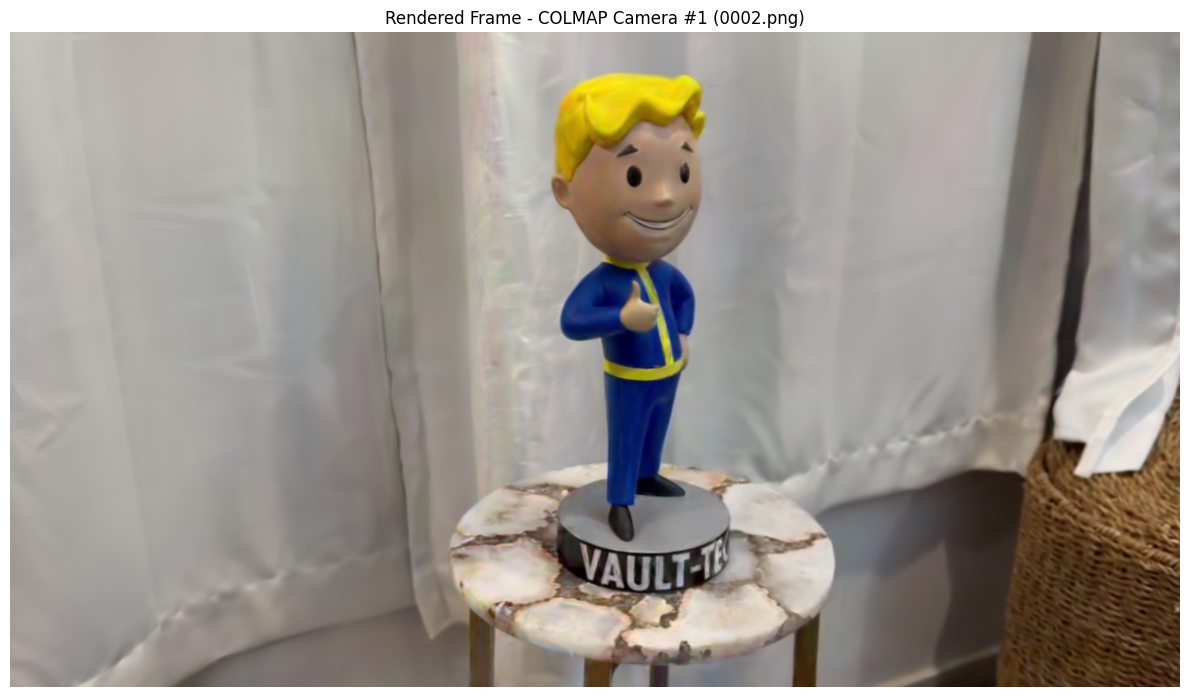

Test frame rendered successfully!
Image range: [0.000, 1.000]


In [12]:
# Render a single test frame
# Choose camera: 
#   - Use colmap_c2ws[i] for original training view (i = 0 to 22)
#   - Use orbit_c2ws[i] for synthetic orbit view (i = 0 to 119)

use_colmap_camera = True  # Set to False to use orbit camera
test_frame_idx = 1  # Change this to render different views

if use_colmap_camera:
    c2w = colmap_c2ws[test_frame_idx]
    print(f"Using COLMAP training camera #{test_frame_idx}: {image_names[test_frame_idx]}")
else:
    c2w = orbit_c2ws[test_frame_idx]
    print(f"Using synthetic orbit camera #{test_frame_idx}")

# Use original full resolution
H = cam_parameters['height']
W = cam_parameters['width']
H_src = cam_parameters['height']
W_src = cam_parameters['width']
fx, fy = cam_parameters['fx'], cam_parameters['fy']
cx, cy = cam_parameters['cx'], cam_parameters['cy']
fx, fy, cx, cy = scale_intrinsics(H, W, H_src, W_src, fx, fy, cx, cy)

print(f"Rendering at resolution: {W} x {H}")
print(f"Scaled intrinsics: fx={fx:.2f}, fy={fy:.2f}, cx={cx:.2f}, cy={cy:.2f}")

# Evaluate SH and render
color = evaluate_sh(f_dc, f_rest, pos, c2w)
img = render(pos, color, opacity_raw, sigma, c2w, H, W, fx, fy, cx, cy)

# Display the result
img_np = img.cpu().detach().numpy()
plt.figure(figsize=(12, 8))
plt.imshow(img_np)
if use_colmap_camera:
    plt.title(f'Rendered Frame - COLMAP Camera #{test_frame_idx} ({image_names[test_frame_idx]})')
else:
    plt.title(f'Rendered Frame - Orbit Camera #{test_frame_idx}')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Test frame rendered successfully!")
print(f"Image range: [{img_np.min():.3f}, {img_np.max():.3f}]")


=== Diagnostic: Sample Color Values ===
f_dc shape: torch.Size([184301, 3, 1])
f_rest shape: torch.Size([184301, 3, 15])

First 3 Gaussians DC values (should be RGB):
f_dc[0]: [[-0.14664413]
 [-0.27962628]
 [-0.33482876]]
f_dc[1]: [[-1.2938228]
 [-1.3853889]
 [-1.6228321]]
f_dc[2]: [[-0.14684439]
 [-0.55715305]
 [-0.80435705]]

First 3 computed colors:
color[0]: [0.4747131  0.4582316  0.41252762]
color[1]: [0.18603554 0.12588614 0.        ]
color[2]: [0.47163048 0.41813248 0.27080232]

=== Original vs Rendered Comparison ===
Original image shape: (707, 1262, 3)
Rendered image shape: (707, 1262, 3)
Original range: [0.000, 0.992]
Rendered range: [0.000, 1.000]


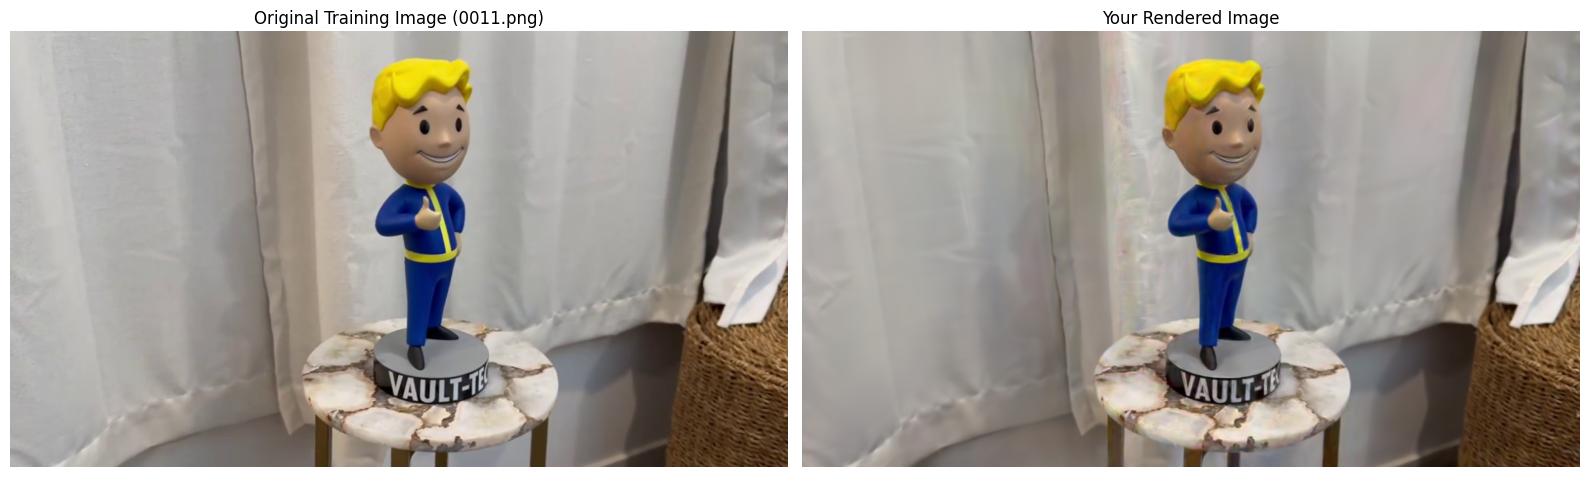

In [13]:
# Diagnostic: Check a few sample colors
print("\n=== Diagnostic: Sample Color Values ===")
print(f"f_dc shape: {f_dc.shape}")
print(f"f_rest shape: {f_rest.shape}")
print(f"\nFirst 3 Gaussians DC values (should be RGB):")
print(f"f_dc[0]: {f_dc[0].cpu().numpy()}")
print(f"f_dc[1]: {f_dc[1].cpu().numpy()}")
print(f"f_dc[2]: {f_dc[2].cpu().numpy()}")

print(f"\nFirst 3 computed colors:")
print(f"color[0]: {color[0].cpu().numpy()}")
print(f"color[1]: {color[1].cpu().numpy()}")
print(f"color[2]: {color[2].cpu().numpy()}")

# Compare with original rendering from same view
import os
# Dynamically set path based on test_frame_idx when using COLMAP camera
if use_colmap_camera:
    original_img_path = f"vaultboy/images/{image_names[test_frame_idx]}"
else:
    original_img_path = r"d:\Projects\00_GaussianSplattingFromScratch\data\boy\images\0001.png"  # Default for orbit views
if os.path.exists(original_img_path):
    from PIL import Image
    original_img = np.array(Image.open(original_img_path)) / 255.0
    print(f"\n=== Original vs Rendered Comparison ===")
    print(f"Original image shape: {original_img.shape}")
    print(f"Rendered image shape: {img_np.shape}")
    print(f"Original range: [{original_img.min():.3f}, {original_img.max():.3f}]")
    print(f"Rendered range: [{img_np.min():.3f}, {img_np.max():.3f}]")
    
    # Show side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Training Image (0011.png)')
    axes[0].axis('off')
    axes[1].imshow(img_np)
    axes[1].set_title('Your Rendered Image')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print(f"\nOriginal image not found at: {original_img_path}")

## 9. Generate Novel Views with Camera Interpolation

**Purpose**: Generate smooth novel views by interpolating camera poses between multiple consecutive training cameras to create a longer, continuous video.

**Why Interpolation?**
- **Smooth motion**: Creates continuous camera trajectories instead of random jumps
- **True novel views**: Generates viewpoints not in the training set
- **Video quality**: Results in smooth, professional-looking video output
- **Coverage**: Interpolating across multiple cameras provides better scene coverage

**Implementation**:

1. **Multi-segment interpolation**:
   - Select training cameras from index 0 to 10 (11 cameras total)
   - Create 10 segments: (0→1), (1→2), ..., (9→10)
   - Generate 20 frames per segment = ~190 total frames
   
2. **SLERP for rotation**:
   - Convert rotation matrices to quaternions
   - Use Spherical Linear Interpolation (SLERP) for smooth rotation
   - Avoids gimbal lock and provides constant angular velocity
   
3. **Linear interpolation for translation**:
   - Interpolate camera position linearly: `t = t_start + α * (t_end - t_start)`
   - Simple and effective for camera movement

4. **Avoiding duplicates**:
   - Skip the last frame of each segment (except final segment)
   - Prevents duplicate frames at segment boundaries

**Algorithm Overview**:
```python
for each consecutive pair (cam_i, cam_i+1):
    for frame j in [0, frames_per_segment-1]:
        t = j / (frames_per_segment - 1)  # [0, 1]
        
        # Rotation: SLERP between quaternions
        q_interp = slerp(q_start, q_end, t)
        R_interp = quaternion_to_rotation_matrix(q_interp)
        
        # Translation: Linear interpolation
        t_interp = t_start + t * (t_end - t_start)
        
        # Build c2w matrix
        c2w[0:3, 0:3] = R_interp
        c2w[0:3, 3] = t_interp
```

**Expected Output**:
- 191 smoothly interpolated camera poses (19 frames × 10 segments + 1 final frame)
- Continuous trajectory through cameras 0→1→2→...→10
- Ready for rendering smooth, longer video sequence

In [14]:
# Create output directory
os.makedirs('novel_views', exist_ok=True)

def interpolate_camera_poses(c2w_start, c2w_end, num_frames):
    """
    Interpolate camera poses between two camera positions.
    Uses linear interpolation for translation and SLERP for rotation.
    
    Args:
        c2w_start: [4, 4] Starting camera-to-world matrix
        c2w_end: [4, 4] Ending camera-to-world matrix
        num_frames: Number of interpolated frames (including start and end)
    
    Returns:
        interpolated_c2ws: List of [4, 4] interpolated camera-to-world matrices
    """
    def rotation_matrix_to_quaternion(R):
        """Convert rotation matrix to quaternion [w, x, y, z]"""
        trace = R[0, 0] + R[1, 1] + R[2, 2]
        
        if trace > 0:
            s = 0.5 / torch.sqrt(trace + 1.0)
            w = 0.25 / s
            x = (R[2, 1] - R[1, 2]) * s
            y = (R[0, 2] - R[2, 0]) * s
            z = (R[1, 0] - R[0, 1]) * s
        elif R[0, 0] > R[1, 1] and R[0, 0] > R[2, 2]:
            s = 2.0 * torch.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
            w = (R[2, 1] - R[1, 2]) / s
            x = 0.25 * s
            y = (R[0, 1] + R[1, 0]) / s
            z = (R[0, 2] + R[2, 0]) / s
        elif R[1, 1] > R[2, 2]:
            s = 2.0 * torch.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
            w = (R[0, 2] - R[2, 0]) / s
            x = (R[0, 1] + R[1, 0]) / s
            y = 0.25 * s
            z = (R[1, 2] + R[2, 1]) / s
        else:
            s = 2.0 * torch.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
            w = (R[1, 0] - R[0, 1]) / s
            x = (R[0, 2] + R[2, 0]) / s
            y = (R[1, 2] + R[2, 1]) / s
            z = 0.25 * s
        
        return torch.tensor([w, x, y, z], device=R.device, dtype=R.dtype)
    
    def quaternion_to_rotation_matrix(q):
        """Convert quaternion [w, x, y, z] to rotation matrix"""
        w, x, y, z = q[0], q[1], q[2], q[3]
        
        R = torch.zeros((3, 3), device=q.device, dtype=q.dtype)
        R[0, 0] = 1 - 2*y*y - 2*z*z
        R[0, 1] = 2*x*y - 2*w*z
        R[0, 2] = 2*x*z + 2*w*y
        R[1, 0] = 2*x*y + 2*w*z
        R[1, 1] = 1 - 2*x*x - 2*z*z
        R[1, 2] = 2*y*z - 2*w*x
        R[2, 0] = 2*x*z - 2*w*y
        R[2, 1] = 2*y*z + 2*w*x
        R[2, 2] = 1 - 2*x*x - 2*y*y
        
        return R
    
    def slerp(q1, q2, t):
        """Spherical linear interpolation between two quaternions"""
        # Normalize quaternions
        q1 = q1 / (q1.norm() + 1e-8)
        q2 = q2 / (q2.norm() + 1e-8)
        
        # Compute dot product
        dot = torch.sum(q1 * q2)
        
        # If dot product is negative, negate one quaternion to take shorter path
        if dot < 0.0:
            q2 = -q2
            dot = -dot
        
        # If quaternions are very close, use linear interpolation
        if dot > 0.9995:
            result = q1 + t * (q2 - q1)
            return result / (result.norm() + 1e-8)
        
        # Calculate angle between quaternions
        theta_0 = torch.acos(torch.clamp(dot, -1.0, 1.0))
        theta = theta_0 * t
        
        # Compute interpolated quaternion
        q2_orthogonal = q2 - q1 * dot
        q2_orthogonal = q2_orthogonal / (q2_orthogonal.norm() + 1e-8)
        
        result = q1 * torch.cos(theta) + q2_orthogonal * torch.sin(theta)
        return result
    
    # Extract rotation and translation
    R_start = c2w_start[:3, :3]
    t_start = c2w_start[:3, 3]
    R_end = c2w_end[:3, :3]
    t_end = c2w_end[:3, 3]
    
    # Convert rotations to quaternions
    q_start = rotation_matrix_to_quaternion(R_start)
    q_end = rotation_matrix_to_quaternion(R_end)
    
    # Interpolate
    interpolated_c2ws = []
    for i in range(num_frames):
        t = i / (num_frames - 1) if num_frames > 1 else 0.0
        
        # SLERP for rotation
        q_interp = slerp(q_start, q_end, t)
        R_interp = quaternion_to_rotation_matrix(q_interp)
        
        # Linear interpolation for translation
        t_interp = t_start + t * (t_end - t_start)
        
        # Construct interpolated c2w matrix
        c2w_interp = torch.eye(4, device=c2w_start.device, dtype=c2w_start.dtype)
        c2w_interp[:3, :3] = R_interp
        c2w_interp[:3, 3] = t_interp
        
        interpolated_c2ws.append(c2w_interp)
    
    return interpolated_c2ws

# Generate novel views by interpolating between cameras 0 to 10
start_camera_idx = 0
end_camera_idx = 10
frames_per_segment = 20  # Frames between each consecutive pair

novel_c2ws = []
for i in range(start_camera_idx, end_camera_idx):
    c2w_start = colmap_c2ws[i]
    c2w_end = colmap_c2ws[i + 1]
    
    # Interpolate between this pair
    # Skip the last frame of each segment except the final one to avoid duplicates
    num_frames = frames_per_segment if i < end_camera_idx - 1 else frames_per_segment
    segment_c2ws = interpolate_camera_poses(c2w_start, c2w_end, num_frames)
    
    # Add all frames from this segment, excluding the last one (except for the final segment)
    if i < end_camera_idx - 1:
        novel_c2ws.extend(segment_c2ws[:-1])  # Exclude last frame to avoid duplication
    else:
        novel_c2ws.extend(segment_c2ws)  # Include last frame for final segment

print(f"Generated {len(novel_c2ws)} interpolated views")
print(f"  Interpolating between cameras {start_camera_idx} to {end_camera_idx}")
print(f"  Images: {image_names[start_camera_idx]} → ... → {image_names[end_camera_idx]}")
print(f"  {frames_per_segment} frames per segment × {end_camera_idx - start_camera_idx} segments")
print(f"  Using SLERP for rotation and linear interpolation for translation")

# Render all frames
with torch.no_grad():
    for i, c2w_i in tqdm(enumerate(novel_c2ws), total=len(novel_c2ws), desc="Rendering frames"):
        c2w = c2w_i
        # Use 1/2 resolution for faster rendering
        H = cam_parameters['height'] // 2
        W = cam_parameters['width'] // 2
        H_src = cam_parameters['height']
        W_src = cam_parameters['width']
        # Use actual COLMAP camera parameters
        fx, fy = cam_parameters['fx'], cam_parameters['fy']
        cx, cy = cam_parameters['cx'], cam_parameters['cy']
        fx, fy, cx, cy = scale_intrinsics(H, W, H_src, W_src, fx, fy, cx, cy)

        color = evaluate_sh(f_dc, f_rest, pos, c2w)
        img = render(pos, color, opacity_raw, sigma, c2w, H, W, fx, fy, cx, cy)

        Image.fromarray((img.cpu().detach().numpy() * 255).astype(np.uint8)).save(
            f'novel_views/frame_{i:04d}.png'
        )

print(f"\nRendering complete! {len(novel_c2ws)} frames saved to 'novel_views/' directory.")

Generated 191 interpolated views
  Interpolating between cameras 0 to 10
  Images: 0001.png → ... → 0011.png
  20 frames per segment × 10 segments
  Using SLERP for rotation and linear interpolation for translation


Rendering frames: 100%|██████████| 191/191 [02:30<00:00,  1.27it/s]


Rendering complete! 191 frames saved to 'novel_views/' directory.


## 10. Create Video from Frames

Combines all rendered frame images from the `novel_views/` directory into an MP4 video file using OpenCV's VideoWriter with H.264 encoding.

In [15]:
import cv2
import glob
import os

# Get all frame files sorted by name
image_files = sorted(glob.glob('novel_views/frame_*.png'))

if len(image_files) == 0:
    print("No frames found in novel_views/. Run the rendering cells first.")
else:
    print(f"Found {len(image_files)} frame files in novel_views/")
    print(f"  First: {os.path.basename(image_files[0])}")
    print(f"  Last: {os.path.basename(image_files[-1])}")
    
    # Read first frame to get dimensions
    frame = cv2.imread(image_files[0])
    if frame is None:
        print(f"Error: Could not read {image_files[0]}")
    else:
        height, width, _ = frame.shape
        
        # Video settings
        fps = 30
        output_path = 'novel_views/orbit_video.mp4'
        
        # Initialize video writer (H.264 codec)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        if not out.isOpened():
            print("Error: Could not open video writer")
        else:
            print(f"\nCreating video from {len(image_files)} frames...")
            print(f"Resolution: {width}×{height}")
            print(f"FPS: {fps}")
            
            # Write all frames to video
            frames_written = 0
            for i, img_file in enumerate(image_files):
                frame = cv2.imread(img_file)
                if frame is not None:
                    out.write(frame)
                    frames_written += 1
                    if (i + 1) % 30 == 0:
                        print(f"  Progress: {i + 1}/{len(image_files)} frames")
                else:
                    print(f"Warning: Could not read frame {img_file}")
            
            out.release()
            
            # Get file size
            file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
            duration = frames_written / fps
            
            print(f"\nVideo created successfully!")
            print(f"  Output: {output_path}")
            print(f"  Frames written: {frames_written}/{len(image_files)}")
            print(f"  Duration: {duration:.1f} seconds")
            print(f"  File size: {file_size_mb:.2f} MB")

Found 191 frame files in novel_views/
  First: frame_0000.png
  Last: frame_0190.png

Creating video from 191 frames...
Resolution: 631×353
FPS: 30
  Progress: 30/191 frames
  Progress: 60/191 frames
  Progress: 90/191 frames
  Progress: 120/191 frames
  Progress: 150/191 frames
  Progress: 180/191 frames

Video created successfully!
  Output: novel_views/orbit_video.mp4
  Frames written: 191/191
  Duration: 6.4 seconds
  File size: 0.89 MB
